## functionality to check OpenStreetMap connectivity of waterways

To understand hydraulic behaviour of the drainage system, we want to know how the network of drains, streams, ditches and rivers is connected. Water can only flow to the outlet through a well connected network. This routine can be used to identify disconnected features. The disconnected features can be either:
- Disconnected also in reality, this is potential cause of problems in the field.
- Disconnected in the dataset only, because some parts of the network were not mapped correctly or were not mapped at all.

The routine works as follows:
- filter out all features (waterways) from the Ramani Huria data. We use the agreed Ramani Huria data model to find these features. 
- select a downstream feature (e.g. a feature that runs into the ocean).
- Find features that are connected to the selected feature. This is like walking the branches of a tree, going up the branch untill it is not connected to the stem anymore. 
- write the result to a shape file (GJSON)

We're testing this for the OSM data across Dar Es Salaam.


First we load all packages needed to run the routine:

In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection

import fiona
import numpy as np
import shapely
from osm2dh import filter_features, check_data_model, write_layer
from DFlowFM_tools import create_feature, add_properties
import logging
import rtree
import copy
from shapely.geometry import (Point, LineString, Polygon,
                              MultiLineString, MultiPoint, MultiPolygon, GeometryCollection)

Below we collect all functions we need for this notebook. We refer to these later on.

In [3]:
def plot_line(ax, ob, **kwargs):
    x, y = ob.xy
    ax.plot(x, y, **kwargs) 

def plot_bbox(ax, bbox, **kwargs):
    ax.plot(np.array(bbox)[[0, 2, 2, 0, 0]], np.array(bbox)[[1, 1, 3, 3, 1]], **kwargs)

def check_dict(props, key, value):
    """
    Checks if feature has a key value pair according to filter
    Returns: True or False
    """
    if key in props.keys():
        f = props[key]
    else:
        return False
    # filter on key/values

    if isinstance(value, str):
        # if value is empty strings, pass all objects of key (unless f return nothing)
        if value == '':
            if f in ['', None, '-1']:
                return False  # next feat
        # only matching key-value pairs
        else:
            if f != value:
                return False
    # check against multiple values
    elif isinstance(value, list):
        if f not in value:
            return False
    return True



First, we collect all waterway related features in Dar Es Salaam, following the Ramani Huria data model. We use the function "filter_features" from our set of quality control routines to check this.

In [4]:
osm_fn = r'd:\svn\hyd_tools\sandbox\osmmodelbuilding\input\dar.osm'

# define filter for waterways
key_1 = 'waterway'
values_1 = ['ditch', 'drain', 'stream', 'river', 'culvert']
#values_1 = ['stream', 'river']

key_type = {'osm_id': 'int',
            'width': 'float',
            'depth': 'float',
            'covered': 'str',
            'layer': 'int',
            'diameter': 'float'}

key_ranges = {'width': [0,50],
             'depth': [0,20],
             'covered': ['yes','no'],
             'layer': [-1,0,1],
             'diameter': [0.1,2]}


waterways = filter_features(osm_fn,
                            key=key_1,
                            value=values_1,
                            layer_index=1,
                            wgs2utm=False,
                            logger=logging,
                            bbox=None,
                            )
schema = {'geometry': 'LineString',
          'properties': key_type}

feats_checked = check_data_model(waterways,
                                 check_keys=key_type,
                                 check_ranges=key_ranges,
                                 schema=schema,
                                 keep_original=True)


In [5]:
print('We have {:d} waterways in total'.format(len(feats_checked)))
all_features = feats_checked

We have 9779 waterways in total


Let's make a simple plot of all the selected features. (NOTE: This might take some time...)

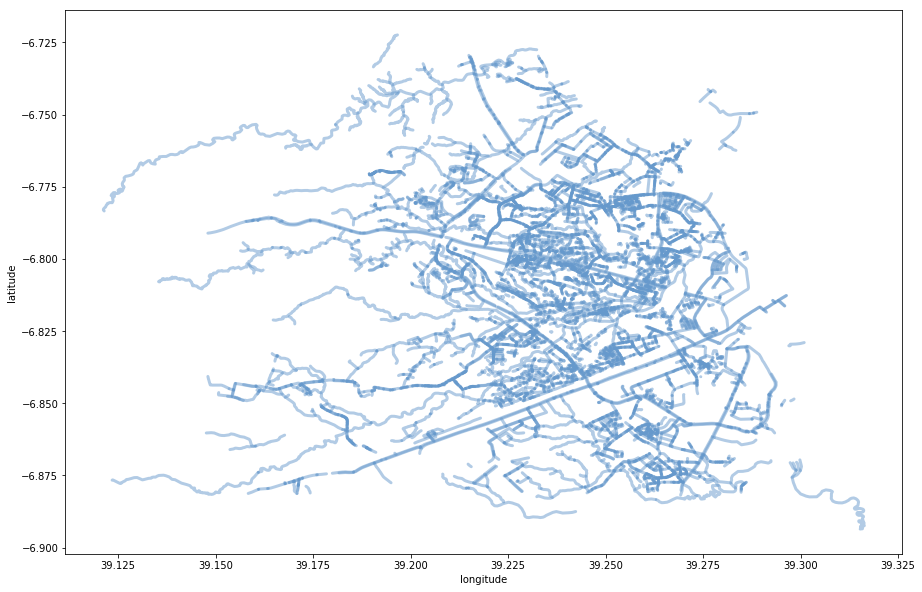

In [6]:
BLUE = '#6699cc'
YELLOW = '#ffcc33' 

# set upa figure
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

# then plot waterways
y = [plot_line(ax, ob['geometry'], color=BLUE, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2) for ob in feats_checked]

plt.xlabel('longitude')
plt.ylabel('latitude')    
plt.savefig('network.png', bbox_inches='tight', dpi=150)

Now we make a list of bounding boxes per feature, so that we can perform spatial indexing on the features. Indexing increases the speed of the routine considerably. Let's also plot to see what that looks like...

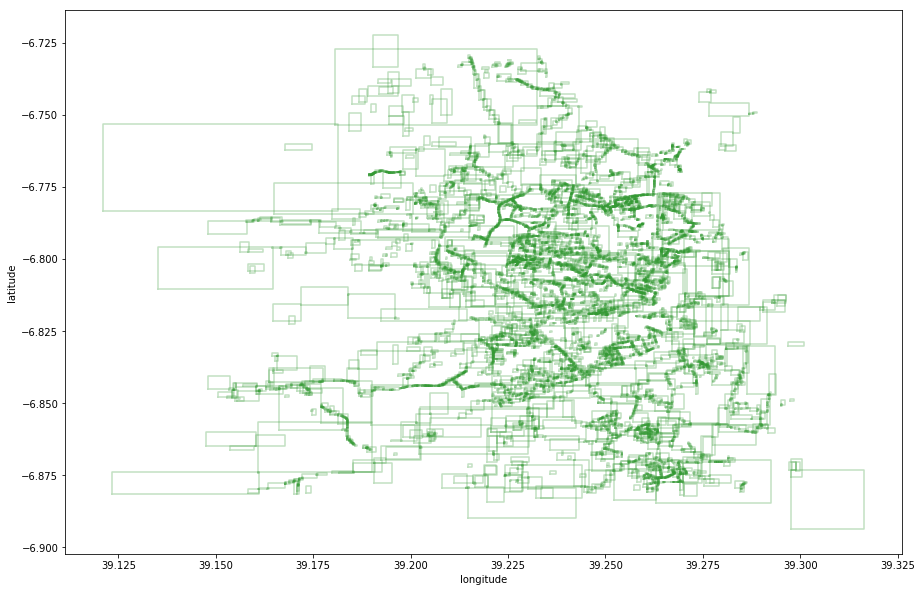

In [7]:
GREEN =  '#339933'
lines_bbox = [f['geometry'].buffer(0.0001).bounds for f in all_features]

##
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

coll = [plt.plot(np.array(line)[[0, 2, 2, 0, 0]], np.array(line)[[1, 1, 3, 3, 1]], color=GREEN, alpha=0.3) for line in lines_bbox]
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.savefig('bbox.png', bbox_inches='tight', dpi=150)

Looks good, now we can build a spatial indexing using rtree to perform spatial indexing and selecting.

In [8]:
tree_idx   = rtree.index.Index()
for i, bbox in enumerate(lines_bbox):
    tree_idx.insert(i, bbox)


Test if we can find the appropriate waterways, that are within bounds of a selected waterway.

In [11]:
osm_selected = 346381791
for i, f in enumerate(all_features):
    if int(f['properties']['osm_id']) == osm_selected:
        print "Selected idx is %s, corresponding to OSM_ID %s" %(i, osm_selected)
        selected_id = i
        
waterway = feats_checked[selected_id]
hits = np.array(list(tree_idx.intersection(lines_bbox[selected_id])))

Selected idx is 448, corresponding to OSM_ID 346381791


Let's plot on the network our selected feature.

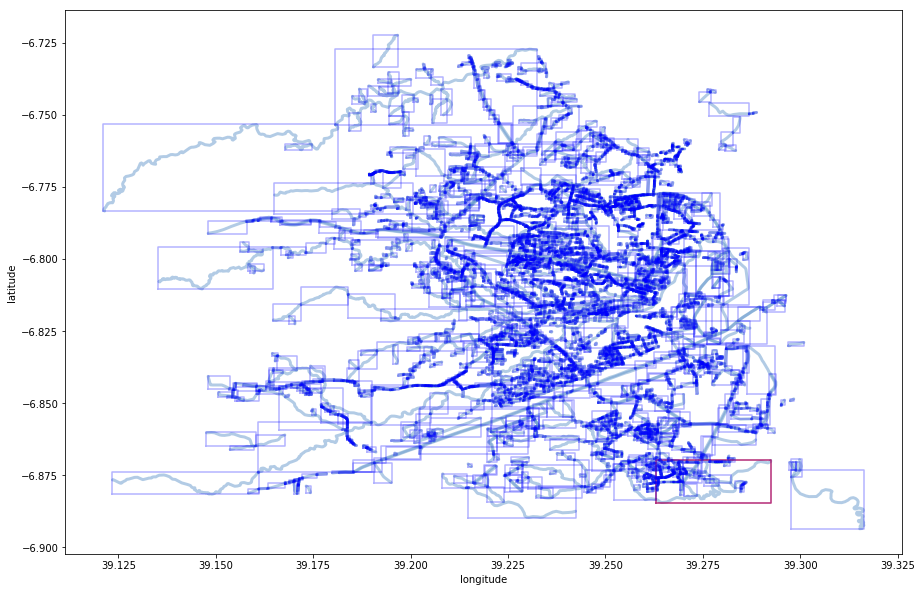

In [12]:
BLUE = '#6699cc'
YELLOW = '#ffcc33' 

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

line = lines_bbox[selected_id]
plot_bbox(ax, line, color='red', alpha=0.7, zorder=2)
# then plot waterways
w = [plot_line(ax, ob['geometry'], color=BLUE, alpha=0.5, linewidth=3, solid_capstyle='round', zorder=1) for ob in list(np.array(all_features))]

# plot the bboxes of waterways
wb = [plot_bbox(ax, line, color='b', alpha=0.3) for line in list(np.array(lines_bbox))]
plt.xlabel('longitude')
plt.ylabel('latitude')    
plt.savefig('bbox_selected.png', bbox_inches='tight', dpi=150)

Okay, now that we have the data in place, we can start checking on connectivity. For this, the function below is used. Input to the function is:
- Feats: This is a list of all selected features, including both geometry and properties for each feature.
- osm_ids: A list of osm_ids of the selected features. Can also be a single osm feature.
- tolerance: Can be used when elements are very close together, but just don't connect. Preferably, this is not used / needed.
- check_keys: The properties of the features to be contained in the final GJSON file.
- logger: Used to write logger information
- schema: The schema of the features, to be used to write to GJSON format.

In [13]:
def check_connectivity(feats, osm_ids=[], tolerance=0.0001, check_keys={}, logger=logging,schema=None):
    ## To be sure, make a copy of the data
    feats_     = copy.copy(feats) 
    ## Build a spatial index to make all faster. 
    tree_idx   = rtree.index.Index()
    lines_bbox = [l['geometry'].buffer(tolerance).bounds for l in feats_]
    for i, bbox in enumerate(lines_bbox):
        tree_idx.insert(i, bbox)
    
    ## Create two new properties, needed to check connectivity. Initial value == 0.
    ## Connected is used to identify features that are connected to a selected feature. The value is then set to that OSM_ID.
    ## Endpoints is used as a counter to be able to loop over the dataset multiple times (needed to find all connected features).
    for i, feat in enumerate(feats_):
        feat['properties']['connected'] = 0
        feat['properties']['endpoints'] = 0
    
    ## Make a list of the selected elements, for which we need to check the connectivity.
    select_ids = [idx for idx in np.arange(0,len(feats_)) if int(feats_[idx]['properties']['osm_id']) in osm_ids]            
    
    ## Now start the actual check, looping over the selected elements.
    for select_id in select_ids:
        ## First set the properties of the selected elements. The field "connected" set to OSM_ID of selected element.
        feats_[int(select_id)]['properties']['connected'] = feats_[select_id]['properties']['osm_id']
        feats_[int(select_id)]['properties']['endpoints'] = 2
        ## Initialize
        to_check = 1
        endpoints_list = [select_id]
        ## Continue checking, untill no more features need to be checked anymore.
        while to_check > 0:
            ## Loop over all endpoints in the list. List is updated every loop.
            for endpoint_id in endpoints_list:
                ## Find all features for which the bounding box connects to the selected element to narrow the number of elements
                ## to loop over. The id's of the connected boxes is contained in the list "hits"
                hits = list(tree_idx.intersection(lines_bbox[int(endpoint_id)], objects=False))
                ## Now loop over the hits and check whether they are really connected or not.
                for i in hits:
                    ## Ugly solution to solve the issue
                    if feats_[i]['properties']['endpoints'] > 0:      
                        feats_[i]['properties']['endpoints'] = feats_[i]['properties']['endpoints'] - 1
                        
                    ## Check if element is not itself, to overcome the issue of endless loop.                   
                    if feats_[i]['properties']['connected'] != feats_[select_id]['properties']['osm_id']: 
                        ## Now check is elements are disjoint. If disjoint, continue to the next step.
                        if feats_[i]['geometry'].disjoint(feats_[int(endpoint_id)]['geometry'].buffer(tolerance)):
                            continue
                        else:
                            ## If elements are not disjoint, they are connected.
                            ## Change the properties and add element to the "connected" list, using the OSM_ID of the selected 
                            ## feature.
                            
                            ## Set endpoints to 15. In the next iterations, this means the element can be checked again for other
                            ## connections. Every loop, the value is lowered by 1, untill 0 is reaches and a real endpoint is 
                            ## assumed.
                            feats_[i]['properties']['endpoints'] = 15
                            feats_[i]['properties']['connected'] = feats_[select_id]['properties']['osm_id']
                    
            endpoints_list = [j for j, feat in enumerate(feats_) if feat['properties']['endpoints'] > 0]
            to_check = len(endpoints_list)
    ## Return all features. In the properties, two fields are added, which contain the information about the connectivity.
    return feats_

In [14]:
prop_with_flags = {}
for key in key_type:
    prop_with_flags[key] = key_type[key]
    prop_with_flags[key + '_flag'] = 'int'

schema = {'geometry': 'LineString',
          'properties': prop_with_flags}

feats_connected = check_connectivity(all_features, 
                                     osm_ids = [osm_selected], 
                                     tolerance = 0.0001,
                                     check_keys=key_type,
                                     schema=schema)

Let's have a visual of the connected network. (NOTE: Again, this might take some time...)

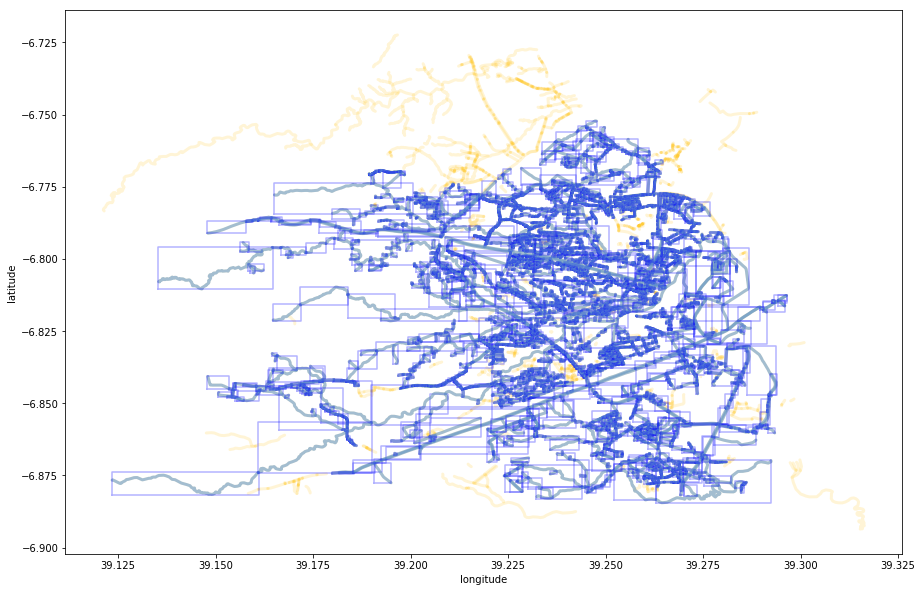

In [15]:
BLUE = '#6699cc'
YELLOW = '#ffcc33' 

# set up a figure
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

# first plot connected elements
x = [plot_line(ax, ob['geometry'], color=YELLOW, alpha=0.2, linewidth=3, solid_capstyle='round', zorder=2) for ob in list(np.array(feats_connected))]
for feat, line in zip(feats_connected, list(np.array(lines_bbox))):
    if int(feat['properties']['connected']) == osm_selected:
        y = plot_line(ax, feat['geometry'], color=BLUE, alpha=0.6, linewidth=3, solid_capstyle='round', zorder=2)
        z = plot_bbox(ax, line, color='b', alpha=0.3)

plt.xlabel('longitude')
plt.ylabel('latitude')    
plt.savefig('connected.png', bbox_inches='tight', dpi=150)

The results can now be written to a GJSON. Note that the schema needs to be updated to also contain the information about the connectivity.

In [16]:
props_schema = schema['properties']

## Here add the two property fields to the schema, so that it can be written to the GJSON file.
props_schema['connected'] = 'int'
props_schema['endpoints'] = 'int'

schema = {'geometry': 'LineString',
          'properties': props_schema}

write_layer(r'd:\svn\hyd_tools\sandbox\osmmodelbuilding\output\test7.json',
            None,
            feats_connected,
            format='GeoJSON',
            write_mode='w',
            crs=fiona.crs.from_epsg(4326),
            schema=schema)

{'geometry': 'LineString', 'properties': {'diameter': 'float', 'layer': 'int', 'osm_id_flag': 'int', 'layer_flag': 'int', 'width_flag': 'int', 'diameter_flag': 'int', 'width': 'float', 'depth': 'float', 'covered_flag': 'int', 'connected': 'int', 'osm_id': 'int', 'covered': 'str', 'depth_flag': 'int', 'endpoints': 'int'}}
{'diameter': None, 'layer': None, 'osm_id_flag': 2, 'layer_flag': 3, 'width_flag': 3, 'diameter_flag': 3, 'width': None, 'depth': None, 'covered_flag': 3, 'connected': '346381791', 'osm_id': '23334736', 'covered': None, 'depth_flag': 3, 'endpoints': 0}
